In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
from pydicom import dcmread
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from pydicom.pixel_data_handlers.util import convert_color_space
import logging
logger = logging.getLogger("pre_process")
import SimpleITK as sitk
from PIL import Image
#from scikit-image import measure, morphology
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
def extract_masks(pixel_array, threshold=40):
    '''
        Extract mask from a dicom file in RGB and annotations in colors
        since for grey colors the RGB channels are equal, calculating the difference for the 3 channels
    '''
    # Calculate the maximum and minimum RGB channel values for each pixel
    img = pixel_array.copy()
    max_vals = np.max(img, axis=2)
    min_vals = np.min(img, axis=2)

    # Check for pixels where the difference between maximum and minimum values is less than or equal to 2
    diff = max_vals - min_vals
    equal_diff_pixels = diff <= threshold

    # Set the equal difference pixels to black (0, 0, 0)
    img[equal_diff_pixels] = [0, 0, 0]
    binary_mask = np.where(img > 0, 255, 0).astype(np.uint8)

    return binary_mask

In [18]:
def generate_masks(tomask_path, save_path):
    for folder in os.listdir(tomask_path):
        folder_path = tomask_path+folder+"/"
        for file in os.listdir(folder_path):
            file_path = folder_path+file
            
            save_dir = os.path.join(save_path, folder)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            saved_filename = os.path.join(save_path, folder,file.replace('.dcm', '_mask.png'))
            if not os.path.exists(saved_filename):
                try: 
                    ds = dcmread(file_path)
                    pixel_array = ds.pixel_array
                    mask = extract_masks(pixel_array)
                    cv2.imwrite(saved_filename, mask)
                except:
                    print(f'Error loading {file_path}')


In [33]:
def transform_to_hu(medical_image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    image = medical_image.pixel_array
    hu_image = image * slope + intercept

    return hu_image

def set_window(img, hu=[-800.,1200.]):
    window = np.array(hu)
    newimg = (img-window[0]) / (window[1]-window[0])
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    newimg = (newimg * 255).astype('uint8')
    return newimg


def zero_center(hu_image):
    hu_image = hu_image - np.mean(hu_image)
    return hu_image

In [34]:
# Load the scans in given folder path
def load_scan(path):
    listdir = os.listdir(path)

    print(listdir.sort())
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #try:
    #    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    #except:
    #    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    #    print('Thickness infered')
        
    #for s in slices:
    #    s.SliceThickness = slice_thickness
        
    return slices

In [35]:
def resample(image, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([image.SliceThickness] + image.PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [2]:
DATA_MASK = '../data_mask/'
SAVE_PATH = '../masks/'

#generate_masks(DATA_MASK, SAVE_PATH)

# Dicom Preprocessing

In [37]:
def crop_dicom(ds, output_path, roi_box):
    # Read the DICOM image
    

    
    # Convert DICOM to SimpleITK image
    image = sitk.GetImageFromArray(ds.pixel_array)
    image.SetSpacing(ds.PixelSpacing)
    image.SetOrigin(ds.ImagePositionPatient)
    image.SetDirection(ds.ImageOrientationPatient)

    # Define the region of interest (ROI) box [xmin, xmax, ymin, ymax, zmin, zmax]
    roi = [roi_box[0], roi_box[1], roi_box[2], roi_box[3], roi_box[4], roi_box[5]]

    # Crop the image using the ROI box
    cropped_image = image[roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]]

    # Convert SimpleITK image to numpy array
    cropped_array = sitk.GetArrayFromImage(cropped_image)

    # Update DICOM attributes
    ds.Rows, ds.Columns, _ = cropped_array.shape
    ds.PixelData = cropped_array.astype(np.uint16).tobytes()

    # Compute the new direction matrix for the cropped image
    new_direction = []
    for i in range(3):
        new_direction.extend(cropped_image.GetDirection()[i * 3: (i + 1) * 3])
    ds.ImageOrientationPatient = new_direction

    # Save the modified DICOM image
    #ds.save_as(output_path)
    return ds

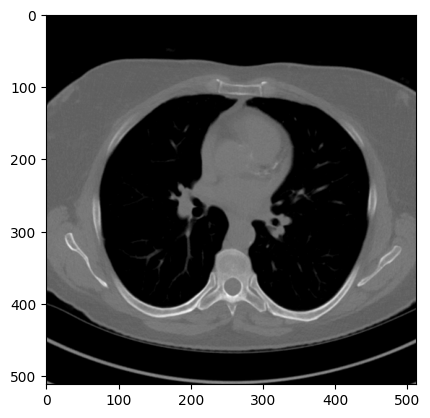

In [55]:
DICOM_PATH = '../data/112/112/IM-0001-0030.dcm'
dcs = dcmread(DICOM_PATH)
im_33 = transform_to_hu(dcs)
new = set_window(im_33, [-800, 1200])
other = zero_center(new)
plt.imshow(other, cmap='gray')


In [9]:
# Read the DICOM image
from scipy.ndimage import zoom

def resize_dcm(ds, size = (256, 256)):
    # Extract the pixel data
    pixel_data = ds.pixel_array
    # Define the desired output size
    output_size = (256, 256)  # Specify the desired width and height

    # Resize the pixel data using the zoom function from scipy.ndimage
    resized_data = zoom(pixel_data, (output_size[0] / pixel_data.shape[0], output_size[1] / pixel_data.shape[1]))

    # Update DICOM attributes
    ds.Rows, ds.Columns = output_size
    ds.PixelData = resized_data.astype(np.uint16).tobytes()
    ds.RescaleIntercept = 0  # Reset the rescale intercept to 0 if necessary

    plt.imshow(ds.pixel_array, cmap='gray')
    return ds

def crop_dicom(ds, output_path, x_start, x_end, y_start, y_end):
    # Load DICOM image
    dicom_image = ds.copy()

    # Get pixel data
    pixel_array = dicom_image.pixel_array

    # Crop the image
    cropped_array = pixel_array[y_start:y_end, x_start:x_end]

    # Update DICOM metadata
    dicom_image.Rows, dicom_image.Columns = cropped_array.shape
    dicom_image.PixelData = cropped_array.tobytes()

    return dicom_image


In [68]:
# Define the region to crop (in pixels)
x_start = 100
x_end = 400
y_start = 100
y_end = 400

# Call the function to crop the DICOM image
ds_r = crop_dicom(dcs, '', x_start, x_end, y_start, y_end)
plt.imshow(dcs.pixel_array, cmap='gray')

TypeError: crop_dicom() takes 3 positional arguments but 6 were given

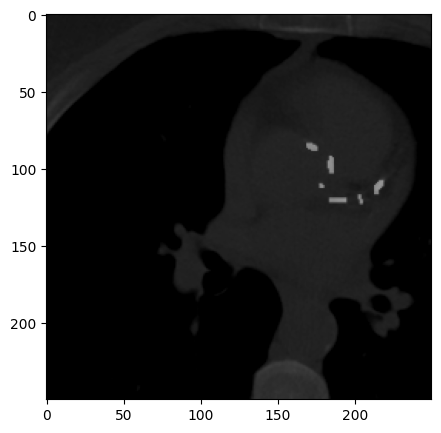

In [61]:
img = Image.open('../masks/112/IM-0001-0030_mask.png')
img = img.resize((512,512))
img = img.crop((x_start, y_start, x_end, y_end))
ds_img = Image.fromarray(other).crop(((x_start, y_start, x_end, y_end)))
plt.figure(figsize = (5,5))
plt.imshow(np.asarray(img))
plt.imshow(ds_img, cmap='gray',alpha=0.6)

In [4]:
import shutil
DATA_PATH = '../data/'
DEST_IMG = '../train_data/train_images/'
DEST_MASK = '../train_data/train_masks/'
SOURCE_MASKS = '../masks/'

def generate_training_set(source_masks, data_path, dest_mask, dest_img):
    for folder in os.listdir(source_masks):
        masks_folder = os.path.join(source_masks, folder)
        img_folder = os.path.join(data_path, folder, folder)
        for masks_file in os.listdir(masks_folder):
            dcm_file = masks_file.replace('_mask.png', '.dcm')
            mask_save_dir = os.path.join(dest_mask, folder)
            dcm_dir = os.path.join(dest_img, folder)
            dcm_save_file = os.path.join(dcm_dir, dcm_file)
            mask_save_file = os.path.join(mask_save_dir, masks_file)
            dcm_file_source = os.path.join(img_folder, dcm_file)
            mask_open_file = os.path.join(source_masks, folder, masks_file)
            if not os.path.exists(dcm_dir):
                os.makedirs(dcm_dir)
            if not os.path.exists(mask_save_dir):
                os.makedirs(mask_save_dir)
            
            if not os.path.exists(dcm_save_file): 
                if not os.path.exists(dcm_file_source):
                    dcm_file_source = os.path.join(data_path, folder, dcm_file)

                shutil.copyfile(dcm_file_source, dcm_save_file)
            
            if not os.path.exists(mask_save_file):
                img = Image.open(mask_open_file)
                img = img.resize((512, 512))
                img.save(mask_save_file)

                    



In [104]:
generate_training_set(SOURCE_MASKS, DATA_PATH, DEST_MASK, DEST_IMG)

In [106]:
lis = os.listdir(DEST_IMG)

In [107]:
lis[0]

'2'

In [2]:
from CACDataset import CACDataset
DATA_PATH = '../data/'
DEST_IMG = '../train_data/train_images/'
DEST_MASK = '../train_data/train_masks/'
SOURCE_MASKS = '../masks/'

dataset = CACDataset(DEST_IMG, DEST_MASK)


In [3]:
image, mask = dataset.__getitem__(0)

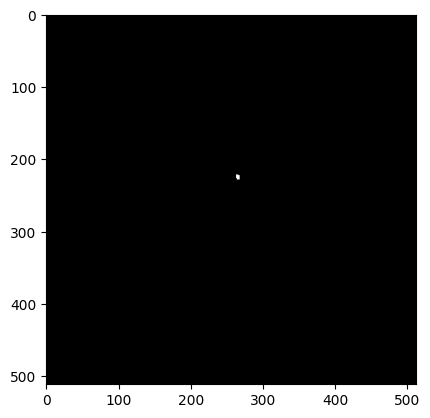

In [6]:
plt.imshow(mask[16], cmap='gray')

In [5]:
k = mask[16]